### Convolutional Autoencoder

In [99]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D 

In [100]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            ]))
ds = torch.utils.data.Subset(ds_full, range(1024))

In [101]:
def Draw(x):
    with torch.no_grad():
        plt.imshow(x.squeeze().detach().numpy(), cmap='gray');
        plt.axis('off');

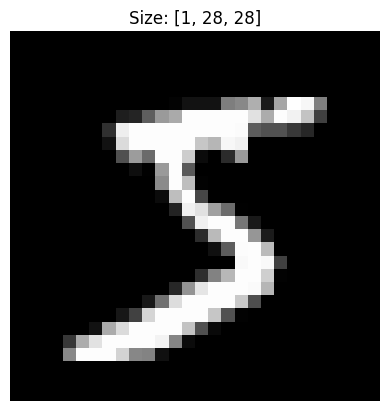

In [102]:
with torch.no_grad():
    x,t = ds.__getitem__(0)
    Draw(x)
    plt.title(f'Size: {list(x.size())}')
plt.show()

In [103]:
# Batched, for training
batch_size_train = 16
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)
x , t = ds.__getitem__(0)
print(x.size())
print(x)

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

# Complete the ConvAE class

In [125]:
class ConvAE(nn.Module):
    def __init__(self, img_size=28, embedding_dim=3):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        
        # Hardcoded 128 instead of embedding_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),                       
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),                       
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Flatten(),                             
            nn.Linear(64 * 7 * 7, embedding_dim)                
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 64 * 7 * 7),               
            nn.ReLU(True),
            nn.Unflatten(1, (64, 7, 7)),              
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), 
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0), 
            nn.ReLU(True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1), 
            nn.Sigmoid()                              
        )

    def encode(self, x):
        x = self.encoder(x)
        return x 
    
    def decode(self, x):
        x = self.decoder(x)
        return x 
  
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x 


# Create and Train the Model

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


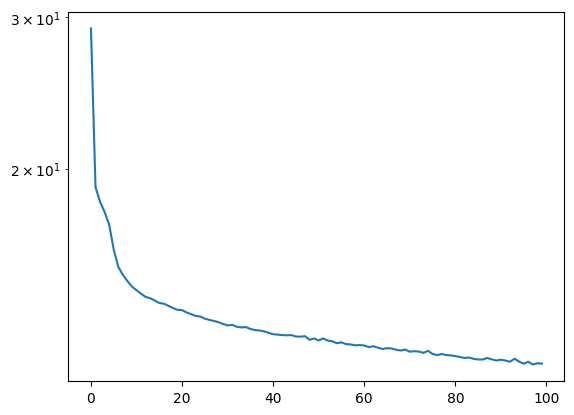

In [126]:
# Setup and Train
net = ConvAE(img_size=img_size, embedding_dim=3)
loss = nn.BCELoss()
optim = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Train it
for epoch in tqdm(range(100)):
    total_loss = 0.
    for x, y in train_dl:
        #print(x)
        xhat = net(x)
        l = loss(xhat, x)
        optim.zero_grad()
        for p in net.parameters():
            l += 0.0005*p.norm(2)
        total_loss += l.item()
        l.backward()
        optim.step()
    net.losses.append(total_loss)

fig3 = plt.figure()
plt.plot(net.losses);
plt.yscale('log');

# Plot the Hidden Layer

In [127]:
# Here are 10 colours you can use. But feel free to use others, too.
colour_options = ['k', 'tab:brown', 'r', 'orange', 'gold', 'lawngreen', 'forestgreen', 'blue', 'mediumpurple', 'gray']
for x, y in train_all:
    print("This loop only runs once to get the hidden layer and y's value")
    h = net.encode(x).detach().numpy()
    y_val = y.detach().numpy()
    y_hat = net(x)
print(h.shape)
print(y_val.shape)
#print(h[:,0])
print(h)
#print(h[:,2])
print(y_val)
print(net.losses[-1])

This loop only runs once to get the hidden layer and y's value
(1024, 3)
(1024,)
[[ -3.6064005  -7.740219    8.741566 ]
 [-22.855259  -14.021506   16.432972 ]
 [  1.0356838 -13.618726  -16.179657 ]
 ...
 [ -5.9079194 -10.297764   15.624716 ]
 [ 27.97062    -6.8365088  -1.0467529]
 [ 16.276697   -1.5730937   4.995496 ]]
[5 0 4 ... 3 7 7]
11.881170570850372


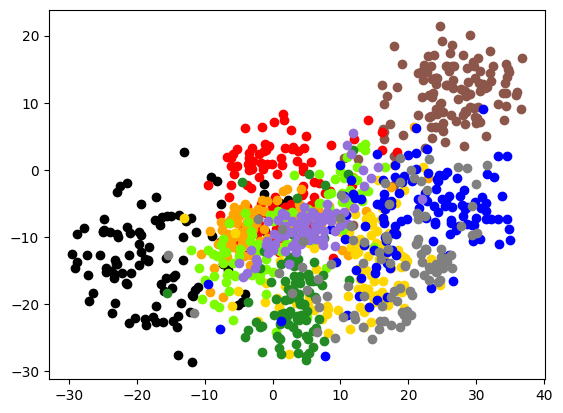

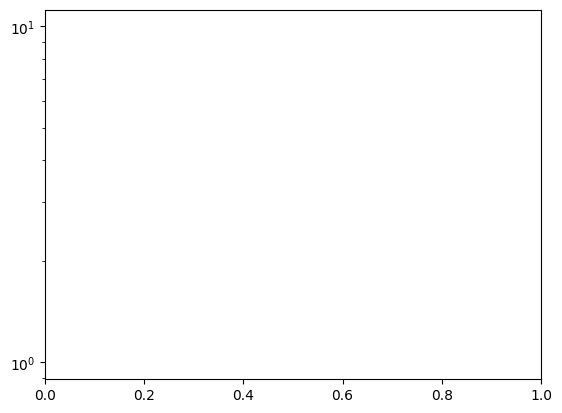

In [134]:
# You can create three 2D planar projections.
fig6 = plt.figure()

for i in range(10):
    class_indices = np.where(y_val == i)
    plt.scatter(h[class_indices,0], h[class_indices,1], color = colour_options[i], marker='o')
plt.show()
plt.yscale('log');


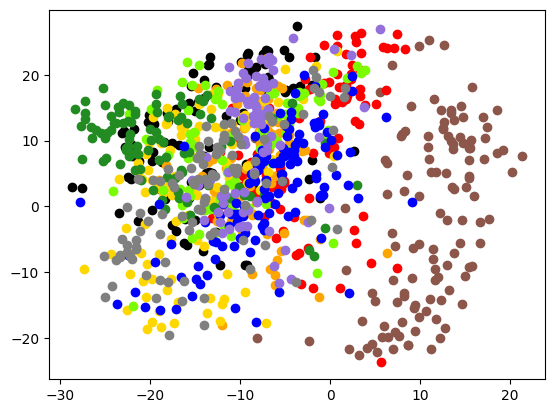

In [130]:
for i in range(10):
    class_indices = np.where(y_val == i)
    scatter = plt.scatter(h[class_indices,1], h[class_indices,2], color = colour_options[i], marker='o')
plt.show()

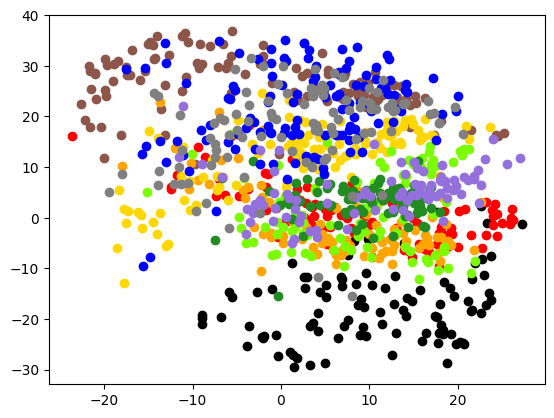

In [131]:
for i in range(10):
    class_indices = np.where(y_val == i)
    scatter = plt.scatter(h[class_indices,2], h[class_indices,0], color = colour_options[i], marker='o')
plt.show()

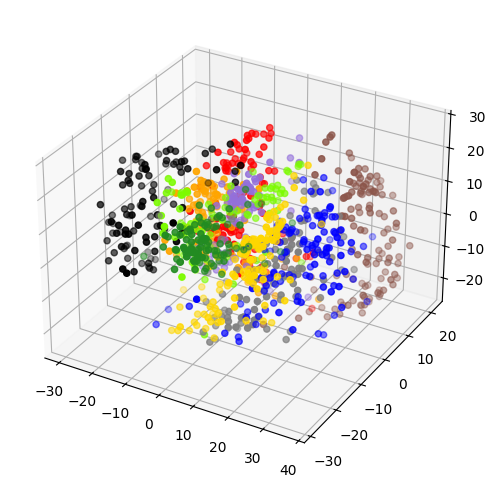

In [132]:
# Or you can plot a 3D scatter plot.
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(...)
#===== YOUR CODE HERE =====
# Plot the scatter points
for i in range(10):
    class_indices = np.where(y_val == i)
    scatter = ax.scatter(h[class_indices,0], h[class_indices,1], h[class_indices,2], color = colour_options[i], marker='o')
plt.show()



# Plot to Reconstruct the Images

Processing class 0, index 1
Input shape: torch.Size([1, 1, 28, 28])


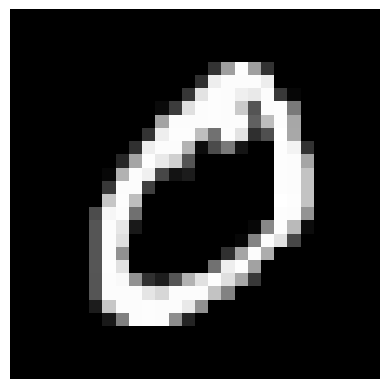

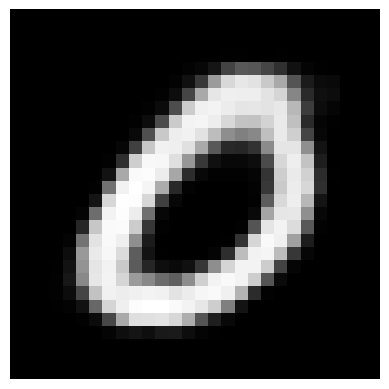

Processing class 1, index 3
Input shape: torch.Size([1, 1, 28, 28])


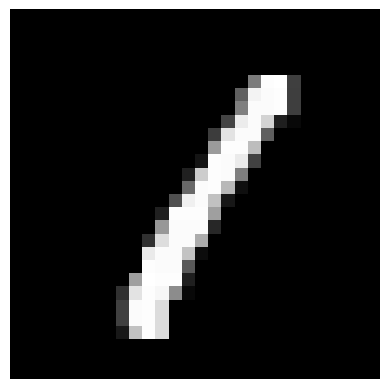

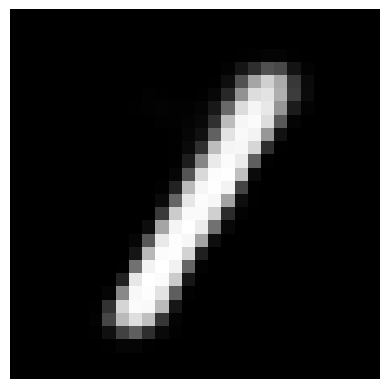

Processing class 2, index 5
Input shape: torch.Size([1, 1, 28, 28])


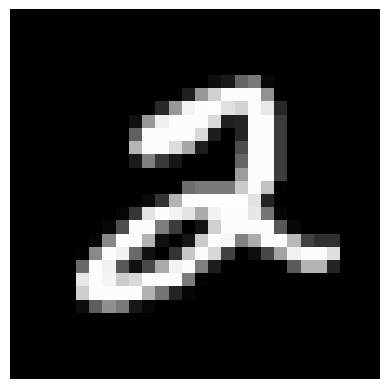

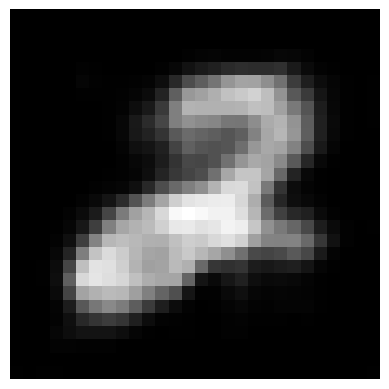

Processing class 3, index 7
Input shape: torch.Size([1, 1, 28, 28])


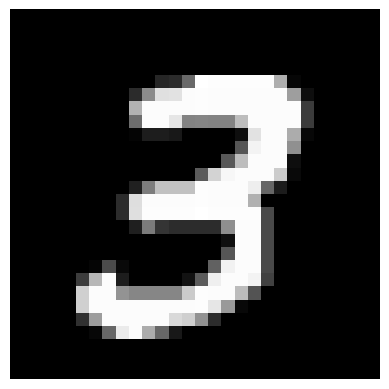

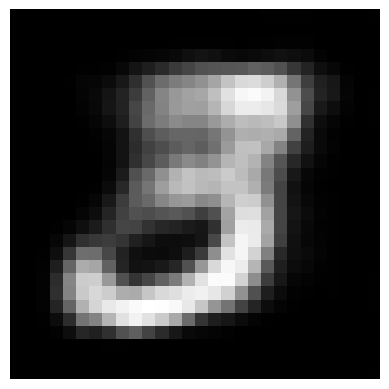

Processing class 4, index 2
Input shape: torch.Size([1, 1, 28, 28])


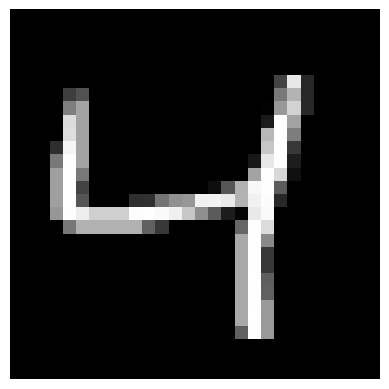

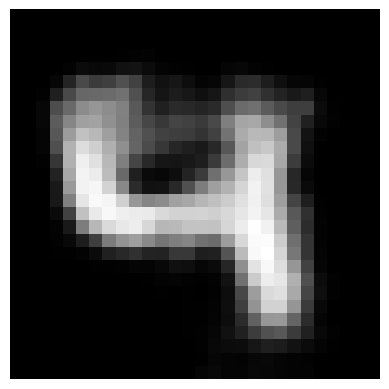

Processing class 5, index 0
Input shape: torch.Size([1, 1, 28, 28])


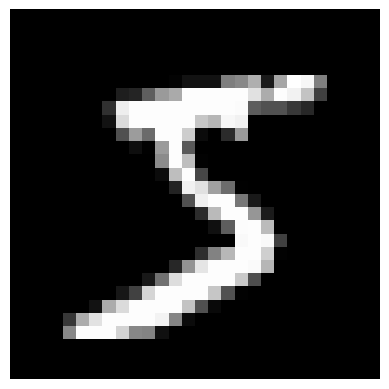

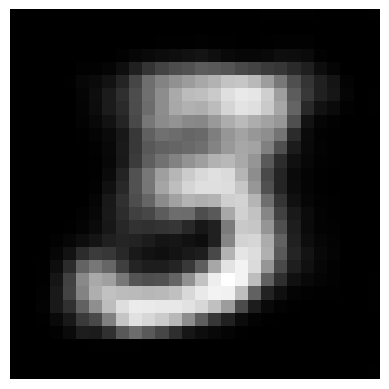

Processing class 6, index 13
Input shape: torch.Size([1, 1, 28, 28])


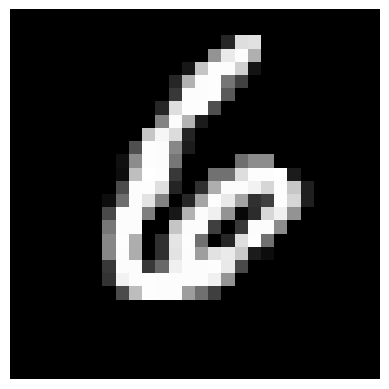

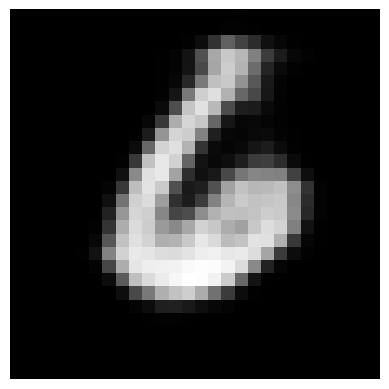

Processing class 7, index 15
Input shape: torch.Size([1, 1, 28, 28])


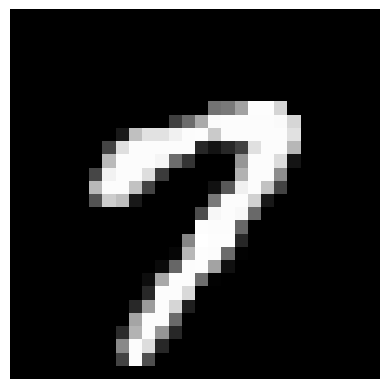

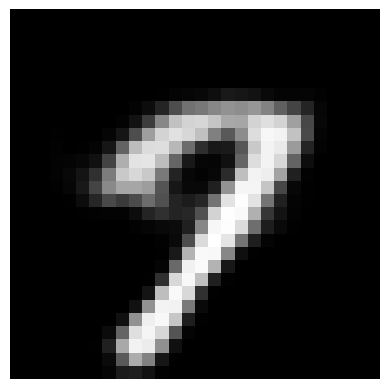

Processing class 8, index 17
Input shape: torch.Size([1, 1, 28, 28])


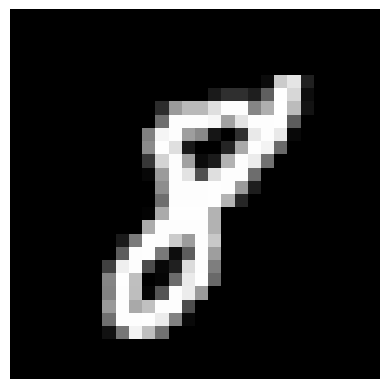

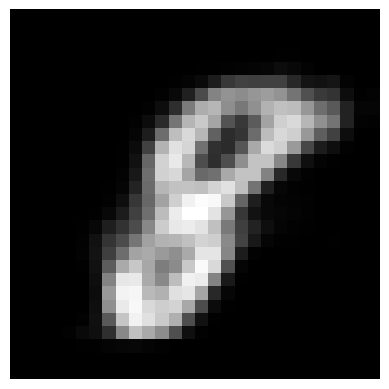

Processing class 9, index 4
Input shape: torch.Size([1, 1, 28, 28])


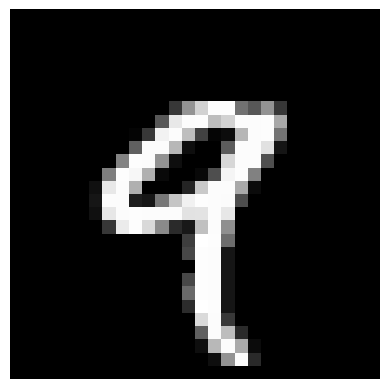

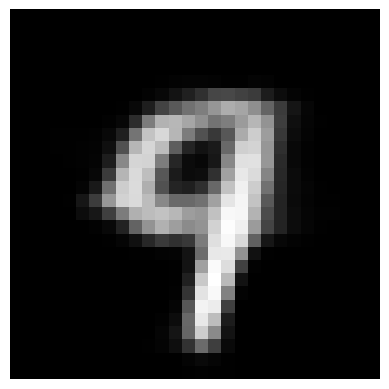

In [139]:
for i in range(10):
        class_indices = np.where(y_val == i)[0]
        if len(class_indices) == 0:
            print(f"Skipping class {i} (no samples)")
            continue
            
        print(f"Processing class {i}, index {class_indices[0]}")
        with torch.no_grad():
            x, t = ds[class_indices[0]] # Using dataset indexing directly
            # x from dataset might not have batch dim if using Subset? 
            # torchvision Subset returns (img, target). Img is 3D tensor (C,H,W)
            # network expects (B,C,H,W)
            x = x.unsqueeze(0) 
            
            print(f"Input shape: {x.shape}")
            Draw(x)
            plt.show()
            
            y_net = net(x)
            Draw(y_net)
            plt.show()
